### VWAP Tick Forecast
1. Fix the bug so it calculates the correct number of shares
2. Pick a stock of your choice, retrieve tick data from WRDS.  
3. Created a merged TAQ file using simtools.py (note: you may need to update it to support the additional tick fields we require for filtering!)
4. Construct a VWAP profile from a selected data range. Select 3 days after your VWAP profile date range
5. Find an optimal schedule factor and coefficient to reduce slippage over those three days with only the schedule factor
6. Repeat the exercise above adding a tick factor
7. Test with both buy and sell orders. Provide examples
8. For each version, show your factor coefficient, "max behind" parameter, tick coefficient and tick window calculation.
9. Ensure that your algo trades the exact number of shares in the order, no more, no less.
10. Provide support for limit orders (i.e. pass in a limit price parameter and take the appropriate (in) action if the limit goes out of range.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import pickle

# load our helper functios
import vwap1 as vw1
import vwap2 as vw2
import vwap3 as vw3

# load our helper functios
%run simtools.py

matplotlib.rcParams[ 'figure.figsize' ] = ( 16, 9 )

###  Merge TAQ

In [2]:
trade_file = 'AAPL_trades.zip'
quote_file = 'AAPL_quotes.zip'

In [3]:
trades = loadtradefile(trade_file)

2020-03-20 16:23:15:034766: load trades
2020-03-20 16:23:22:525639: load complete
2020-03-20 16:23:22:525639: indexing trades
2020-03-20 16:23:51:220224: index trades done


In [4]:
quotes = loadquotefile(quote_file)

2020-03-20 16:23:51:712422: load quotes
2020-03-20 16:25:09:740444: load complete
2020-03-20 16:25:09:770685: indexing quotes
2020-03-20 16:28:48:410258: index quotes done


In [5]:
trades.head()

,symbol,suffix,trade_size,trade_px
2020-03-11 04:00:00.066677969,AAPL,NaN,41,279.36
2020-03-11 04:00:00.124728386,AAPL,NaN,75,279.06
2020-03-11 04:00:00.926151980,AAPL,NaN,1,278.22
2020-03-11 04:00:02.034825071,AAPL,NaN,5,278.22
2020-03-11 04:00:07.507078825,AAPL,NaN,100,278.26


In [6]:
quotes.head()

,exch,bid_px,bid_size,ask_px,ask_size,qu_cond,qu_seqnum,natbbo_ind,qu_cancel,qu_source,symbol,suffix
2020-03-11 04:00:00.009516221,Q,225.00,1,0.00,0,R,1195,2,NaN,N,AAPL,NaN
2020-03-11 04:00:00.068459790,P,267.00,1,0.00,0,R,2179,2,NaN,N,AAPL,NaN
2020-03-11 04:00:00.068527907,P,268.55,1,0.00,0,R,2180,2,NaN,N,AAPL,NaN
2020-03-11 04:00:00.068586104,P,268.55,1,324.75,1,R,2181,4,NaN,N,AAPL,NaN
2020-03-11 04:00:00.068588579,P,268.55,1,324.75,2,R,2182,4,NaN,N,AAPL,NaN


In [7]:
taq = makeTAQfile(trades, quotes)

2020-03-20 16:28:53:915769: start merge
2020-03-20 16:29:21:505774: end merge


In [8]:
taq.to_pickle('AAPL_TAQ.zip')

### VWAP Profile

In [3]:
import yfinance as yf

tick = yf.Ticker("AAPL")
data1=tick.history(period="1mo",interval='1m',start='2020-03-02',end='2020-03-07')
data2=tick.history(period="1mo",interval='1m',start='2020-03-07',end='2020-03-11')

In [4]:
raw_bar_data=pd.concat([data1,data2])

In [5]:
raw_bar_data.drop(columns = ['Dividends','Stock Splits'])

,Open,High,Low,Close,Volume
Datetime,,,,,
2020-03-02 09:30:00-05:00,283.38,283.38,283.38,283.38,3881543
2020-03-02 09:31:00-05:00,283.61,283.61,280.83,282.93,700123
2020-03-02 09:32:00-05:00,282.93,284.23,282.11,282.25,547070
2020-03-02 09:33:00-05:00,282.16,283.85,281.83,282.11,428147
2020-03-02 09:34:00-05:00,281.28,281.28,281.28,281.28,466079
...,...,...,...,...,...
2020-03-10 15:55:00-04:00,283.57,283.63,283.27,283.58,271977
2020-03-10 15:56:00-04:00,283.54,284.00,283.50,284.00,344475
2020-03-10 15:57:00-04:00,284.00,284.19,283.01,283.39,492037


In [6]:
start_of_day = (9 * 60) + 30
raw_bar_data[ 'minute_bars' ] = (raw_bar_data.index.hour * 60) + raw_bar_data.index.minute - start_of_day
raw_bar_data = raw_bar_data[ raw_bar_data.minute_bars <= 389 ]

# calculate the cumulative pct by day
totl_volume = raw_bar_data.groupby( [ raw_bar_data.index.date ] ).tail( 1 )[ 'Volume' ] 
raw_bar_data[ 'accum_volume' ] = raw_bar_data.groupby( [ raw_bar_data.index.date ] ).cumsum()[ 'Volume' ] 
raw_bar_data[ 'accum_pct' ] = raw_bar_data.groupby( [ raw_bar_data.index.date ] )[ 'accum_volume' ].transform( lambda x: x / x.iloc[ -1 ] )

In [7]:
bar_data = raw_bar_data.copy()
minute_bars = bar_data[ 'minute_bars' ]
X = pd.DataFrame( { 'bin': minute_bars, 
                    'bin2' : minute_bars**2, 
                    'bin3' : minute_bars**3, 
                    'bin4' : minute_bars**4, 
                    'bin5' : minute_bars**5 } )
y = bar_data[ 'accum_pct' ]

In [8]:
from sklearn import linear_model as linear_model
lm = linear_model.LinearRegression( fit_intercept = False )
model = lm.fit( X, y )
predictions = lm.predict( X )
# Rsquared
lm.score( X, y )

0.9821377586827679

### VWAP Target Function

In [10]:
vwap_coefs =lm.coef_

In [2]:
# to save time, start from here 
vwap_coefs=[ 7.52284331e-03, -6.02364163e-05,  3.18116884e-07, -8.21264605e-10, 8.14238059e-13]

In [3]:
tickfile = 'AAPL_TAQ.zip'
taq = pd.read_pickle(tickfile)

In [4]:
# set test date
day_1_start = "2020-03-11 9:30"
day_1_end = "2020-03-11 15:59"
day_2_start = "2020-03-12 9:30"
day_2_end = "2020-03-12 15:59"
day_3_start = "2020-03-13 9:30"
day_3_end = "2020-03-13 15:59"
# filter on date
day1 = taq[day_1_start:day_1_end]
day2 = taq[day_2_start:day_2_end]
day3 = taq[day_3_start:day_3_end]
#filter non-NBBO quotes
day1 = day1[((day1.qu_source == 'N') & (day1.natbbo_ind == 4)) | (~day1.trade_size.isna())]
day2 = day2[((day2.qu_source == 'N') & (day2.natbbo_ind == 4)) | (~day2.trade_size.isna())]
day3 = day3[((day3.qu_source == 'N') & (day3.natbbo_ind == 4)) | (~day3.trade_size.isna())]

In [5]:
len(day1),len(day2),len(day3)

(852862, 1340126, 1158057)

### Schedule Factor

a. buy orders

In [39]:
# a list that stored all results in the schedule model
schedule_buyside_result=[]
# set parameters for the schedule factor model
order_quantity = 300000
order_side = 'b'
max_behinds=[500,1000,2000]
schedule_coefficient=[1, 1.5, 2]

In [40]:
# test day 1
day=day1
for behinds in max_behinds:
    for s_coef in schedule_coefficient:
        results = vw1.algo_loop(day, order_side, order_quantity, vwap_coefs, behinds , s_coef)
        summary={'day':day.index[0].strftime("%Y-%m-%d"),
         'order_quantity':order_quantity, 
         'order_side':order_side,
         'parameters':{'max_behind':behinds, 'schedule_coefficient':s_coef},
          'results': results}
        print(results['trades'].shares.sum())
        schedule_buyside_result.append(summary)

2020-03-26 00:48:49:491197: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1
Average stock spread for sample: 0.0558
2020-03-26 00:48:49:733361: starting main loop
2020-03-26 00:52:13:183162: end simulation loop
2020-03-26 00:52:13:183336: order analytics
2020-03-26 00:52:13:282198: VWAP run complete.
300011.0
2020-03-26 00:52:13:365062: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1.5
Average stock spread for sample: 0.0558
2020-03-26 00:52:13:544498: starting main loop
2020-03-26 00:55:35:647010: end simulation loop
2020-03-26 00:55:35:647195: order analytics
2020-03-26 00:55:35:747603: VWAP run complete.
300038.0
2020-03-26 00:55:35:826445: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 2
Average stock spread for sample: 0.0558
2020-03-26 00:55:36:010913: starting main loop
2020-03-26 00:59:02:134884: end simulation loop
2020-03-26 00:59:02:135068: order analytics
2020-03-26 00:59:02:231844: VWAP run complete.
300000
2020

In [44]:
# test day 2
day=day2
for behinds in max_behinds:
    for s_coef in schedule_coefficient:
        results = vw1.algo_loop(day, order_side, order_quantity, vwap_coefs, behinds , s_coef)
        summary={'day':day.index[0].strftime("%Y-%m-%d"),
         'order_quantity':order_quantity, 
         'order_side':order_side,
         'parameters':{'max_behind':behinds, 'schedule_coefficient':s_coef},
          'results': results}
        print(results['trades'].shares.sum())
        schedule_buyside_result.append(summary)

2020-03-26 10:35:06:455022: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1
Average stock spread for sample: 0.0768
2020-03-26 10:35:06:763800: starting main loop
2020-03-26 10:40:48:411930: end simulation loop
2020-03-26 10:40:48:412053: order analytics
2020-03-26 10:40:48:598990: VWAP run complete.
300016.0
2020-03-26 10:40:48:768796: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1.5
Average stock spread for sample: 0.0768
2020-03-26 10:40:49:121151: starting main loop
2020-03-26 10:46:31:963536: end simulation loop
2020-03-26 10:46:31:963704: order analytics
2020-03-26 10:46:32:116406: VWAP run complete.
300000.0
2020-03-26 10:46:32:227310: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 2
Average stock spread for sample: 0.0768
2020-03-26 10:46:32:505199: starting main loop
2020-03-26 10:52:32:773499: end simulation loop
2020-03-26 10:52:32:773681: order analytics
2020-03-26 10:52:32:931419: VWAP run complete.
300021.0
20

In [45]:
# test day 3
day=day3
for behinds in max_behinds:
    for s_coef in schedule_coefficient:
        results = vw1.algo_loop(day, order_side, order_quantity, vwap_coefs, behinds , s_coef)
        summary={'day':day.index[0].strftime("%Y-%m-%d"),
         'order_quantity':order_quantity, 
         'order_side':order_side,
         'parameters':{'max_behind':behinds, 'schedule_coefficient':s_coef},
          'results': results}
        print(results['trades'].shares.sum())
        schedule_buyside_result.append(summary)

2020-03-26 11:26:53:628594: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1
Average stock spread for sample: 0.0692
2020-03-26 11:26:53:870025: starting main loop
2020-03-26 11:31:42:142571: end simulation loop
2020-03-26 11:31:42:142796: order analytics
2020-03-26 11:31:42:274931: VWAP run complete.
300000.0
2020-03-26 11:31:42:386065: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1.5
Average stock spread for sample: 0.0692
2020-03-26 11:31:42:637752: starting main loop
2020-03-26 11:36:29:754428: end simulation loop
2020-03-26 11:36:29:754613: order analytics
2020-03-26 11:36:29:892427: VWAP run complete.
300000.0
2020-03-26 11:36:30:005183: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 2
Average stock spread for sample: 0.0692
2020-03-26 11:36:30:260710: starting main loop
2020-03-26 11:41:17:355589: end simulation loop
2020-03-26 11:41:17:355776: order analytics
2020-03-26 11:41:17:487698: VWAP run complete.
300002.0
20

In [46]:
with open('schedule_buyside_result.pkl', "wb") as f:
    pickle.dump(schedule_buyside_result, f)

In [51]:
with open('schedule_buyside_result.pkl', "rb") as f:
    schedule_buyside_result=pickle.load(f)

In [52]:
## CALCULATE AVERAGE SLIPPAGE
#extract elements from result summary
slippage=map(lambda x: (x['day'],
                        x['parameters'],
                        x['results']['day_vwap'],
                        x['results']['avg_price']),
             schedule_buyside_result)
# calculate day slippage
slippage=map(lambda x: [x[0],
                        x[1]['max_behind'],
                        x[1]['schedule_coefficient'],
                        (x[2]-x[3])/x[2]*10000],
             slippage)
# calculate average slippage over three testing days
slippage=pd.DataFrame(slippage, columns =['date', 'max_behind', 'schedule_coef', 'slippage']) 
grouped_slippage=slippage.groupby(['max_behind','schedule_coef']).mean().unstack()

In [53]:
grouped_slippage

slippage                      
schedule_coef        1.0        1.5        2.0
max_behind                                    
500            11.306471  10.359066  10.363807
1000           11.571015  10.652066  10.504120
2000           11.668206  11.058983  10.879131

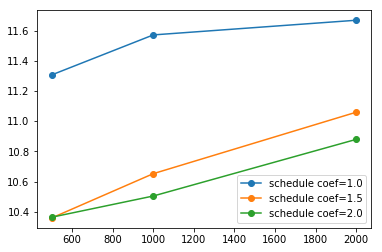

In [54]:
#visualization
plt.plot(max_behinds,grouped_slippage['slippage'].iloc[:,0],'o-',label='schedule coef=1.0')
plt.plot(max_behinds,grouped_slippage['slippage'].iloc[:,1],'o-',label='schedule coef=1.5')
plt.plot(max_behinds,grouped_slippage['slippage'].iloc[:,2],'o-',label='schedule coef=2.0')
plt.legend()
plt.show()

b. sell orders

In [6]:
# a list that stored all results in the schedule model
schedule_sellside_result=[]
# set parameters for the schedule factor model
order_quantity = 300000
order_side = 's'
max_behinds=[500,1000,2000]
schedule_coefficient=[1, 1.5, 2]

In [7]:
# test day 1
day=day1
for behinds in max_behinds:
    for s_coef in schedule_coefficient:
        results = vw1.algo_loop(day, order_side, order_quantity, vwap_coefs, behinds , s_coef)
        summary={'day':day.index[0].strftime("%Y-%m-%d"),
         'order_quantity':order_quantity, 
         'order_side':order_side,
         'parameters':{'max_behind':behinds, 'schedule_coefficient':s_coef},
          'results': results}
        print(results['trades'].shares.sum())
        schedule_sellside_result.append(summary)

2020-03-25 16:09:03:163603: Beginning VWAP run:s,300000 shares, max_behind:500, schedule_coef: 1
Average stock spread for sample: 0.0558
2020-03-25 16:09:04:262364: starting main loop
2020-03-25 16:12:31:240123: end simulation loop
2020-03-25 16:12:31:240335: order analytics
2020-03-25 16:12:31:350394: VWAP run complete.
300037.0
2020-03-25 16:12:31:443664: Beginning VWAP run:s,300000 shares, max_behind:500, schedule_coef: 1.5
Average stock spread for sample: 0.0558
2020-03-25 16:12:31:674639: starting main loop
2020-03-25 16:15:55:614224: end simulation loop
2020-03-25 16:15:55:614410: order analytics
2020-03-25 16:15:55:718772: VWAP run complete.
300022.0
2020-03-25 16:15:55:811655: Beginning VWAP run:s,300000 shares, max_behind:500, schedule_coef: 2
Average stock spread for sample: 0.0558
2020-03-25 16:15:56:009007: starting main loop
2020-03-25 16:19:20:159100: end simulation loop
2020-03-25 16:19:20:159278: order analytics
2020-03-25 16:19:20:259149: VWAP run complete.
300000
2020

In [8]:
# test day 2
day=day2
for behinds in max_behinds:
    for s_coef in schedule_coefficient:
        results = vw1.algo_loop(day, order_side, order_quantity, vwap_coefs, behinds , s_coef)
        summary={'day':day.index[0].strftime("%Y-%m-%d"),
         'order_quantity':order_quantity, 
         'order_side':order_side,
         'parameters':{'max_behind':behinds, 'schedule_coefficient':s_coef},
          'results': results}
        print(results['trades'].shares.sum())
        schedule_sellside_result.append(summary)

2020-03-25 16:42:15:650338: Beginning VWAP run:s,300000 shares, max_behind:500, schedule_coef: 1
Average stock spread for sample: 0.0768
2020-03-25 16:42:15:964674: starting main loop
2020-03-25 16:47:52:575660: end simulation loop
2020-03-25 16:47:52:575842: order analytics
2020-03-25 16:47:52:749210: VWAP run complete.
300033.0
2020-03-25 16:47:52:893663: Beginning VWAP run:s,300000 shares, max_behind:500, schedule_coef: 1.5
Average stock spread for sample: 0.0768
2020-03-25 16:47:53:208585: starting main loop
2020-03-25 16:53:24:289486: end simulation loop
2020-03-25 16:53:24:289668: order analytics
2020-03-25 16:53:24:453226: VWAP run complete.
300041.0
2020-03-25 16:53:24:597350: Beginning VWAP run:s,300000 shares, max_behind:500, schedule_coef: 2
Average stock spread for sample: 0.0768
2020-03-25 16:53:24:910700: starting main loop
2020-03-25 17:04:25:300467: end simulation loop
2020-03-25 17:04:25:300642: order analytics
2020-03-25 17:04:25:499372: VWAP run complete.
300000.0
20

In [9]:
# test day 3
day=day3
for behinds in max_behinds:
    for s_coef in schedule_coefficient:
        results = vw1.algo_loop(day, order_side, order_quantity, vwap_coefs, behinds , s_coef)
        summary={'day':day.index[0].strftime("%Y-%m-%d"),
         'order_quantity':order_quantity, 
         'order_side':order_side,
         'parameters':{'max_behind':behinds, 'schedule_coefficient':s_coef},
          'results': results}
        print(results['trades'].shares.sum())
        schedule_sellside_result.append(summary)

2020-03-25 17:46:20:264760: Beginning VWAP run:s,300000 shares, max_behind:500, schedule_coef: 1
Average stock spread for sample: 0.0692
2020-03-25 17:46:20:514504: starting main loop
2020-03-25 17:51:09:720777: end simulation loop
2020-03-25 17:51:09:720963: order analytics
2020-03-25 17:51:09:861822: VWAP run complete.
300000.0
2020-03-25 17:51:09:972681: Beginning VWAP run:s,300000 shares, max_behind:500, schedule_coef: 1.5
Average stock spread for sample: 0.0692
2020-03-25 17:51:10:242201: starting main loop
2020-03-25 17:55:55:288849: end simulation loop
2020-03-25 17:55:55:289034: order analytics
2020-03-25 17:55:55:425499: VWAP run complete.
300000.0
2020-03-25 17:55:55:541092: Beginning VWAP run:s,300000 shares, max_behind:500, schedule_coef: 2
Average stock spread for sample: 0.0692
2020-03-25 17:55:55:804735: starting main loop
2020-03-25 18:02:15:245223: end simulation loop
2020-03-25 18:02:15:245409: order analytics
2020-03-25 18:02:15:381780: VWAP run complete.
300000.0
20

In [10]:
with open('schedule_sellside_result.pkl', "wb") as f:
    pickle.dump(schedule_sellside_result, f)

In [11]:
with open('schedule_sellside_result.pkl', "rb") as f:
    schedule_sellside_result=pickle.load(f)

In [12]:
## CALCULATE AVERAGE SLIPPAGE
#extract elements from result summary
slippage=map(lambda x: (x['day'],
                        x['parameters'],
                        x['results']['day_vwap'],
                        x['results']['avg_price']),
             schedule_sellside_result)
# calculate day slippage
slippage=map(lambda x: [x[0],
                        x[1]['max_behind'],
                        x[1]['schedule_coefficient'],
                        (x[2]-x[3])/x[2]*10000],
             slippage)
# calculate average slippage over three testing days
slippage=pd.DataFrame(slippage, columns =['date', 'max_behind', 'schedule_coef', 'slippage']) 
grouped_slippage=slippage.groupby(['max_behind','schedule_coef']).mean().unstack()

In [13]:
grouped_slippage

slippage                      
schedule_coef        1.0        1.5        2.0
max_behind                                    
500            12.978204  12.800418  12.807640
1000           12.843301  12.542888  12.722310
2000           12.604459  12.314120  12.421625

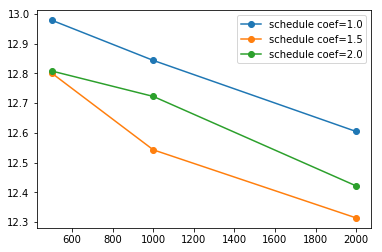

In [15]:
plt.plot(max_behinds,grouped_slippage['slippage'].iloc[:,0],'o-',label='schedule coef=1.0')
plt.plot(max_behinds,grouped_slippage['slippage'].iloc[:,1],'o-',label='schedule coef=1.5')
plt.plot(max_behinds,grouped_slippage['slippage'].iloc[:,2],'o-',label='schedule coef=2.0')
plt.legend()
plt.show()

### Tick Factor

a.buy orders

In [16]:
# a list that stored all results in the schedule model
tick_buyside_result=[]
# set parameters for the schedule factor model
order_quantity = 300000
order_side = 'b'
max_behind=500
schedule_coef=1.5
tick_window=[15,20,25]
tick_coef=[1,1.5,2]

In [17]:
# test day 1
day=day1
for window in tick_window:
    for t_coef in tick_coef:
        results = vw2.algo_loop(day, order_side, order_quantity, vwap_coefs, max_behind, schedule_coef, window, t_coef)
        summary={'day':day.index[0].strftime("%Y-%m-%d"),
         'order_quantity':order_quantity, 
         'order_side':order_side,
         'parameters':{'tick_window':window, 'tick_coefficient':t_coef},
          'results': results}
        print(results['trades'].shares.sum())
        tick_buyside_result.append(summary)

2020-03-25 18:40:13:109684: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1.5，tick_window:15,tick_coef:1
Average stock spread for sample: 0.0558
2020-03-25 18:40:13:326483: starting main loop
2020-03-25 18:44:09:806231: end simulation loop
2020-03-25 18:44:09:806403: order analytics
2020-03-25 18:44:09:912736: VWAP run complete.
300000.0
2020-03-25 18:44:10:011433: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1.5，tick_window:15,tick_coef:1.5
Average stock spread for sample: 0.0558
2020-03-25 18:44:10:213789: starting main loop
2020-03-25 18:47:39:968692: end simulation loop
2020-03-25 18:47:39:968873: order analytics
2020-03-25 18:47:40:074970: VWAP run complete.
300000.0
2020-03-25 18:47:40:167130: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1.5，tick_window:15,tick_coef:2
Average stock spread for sample: 0.0558
2020-03-25 18:47:40:367558: starting main loop
2020-03-25 18:51:10:499821: end simulation loop
2020-03-25 18:5

In [19]:
# test day 2
day=day2
for window in tick_window:
    for t_coef in tick_coef:
        results = vw2.algo_loop(day, order_side, order_quantity, vwap_coefs, max_behind, schedule_coef, window, t_coef)
        summary={'day':day.index[0].strftime("%Y-%m-%d"),
         'order_quantity':order_quantity, 
         'order_side':order_side,
         'parameters':{'tick_window':window, 'tick_coefficient':t_coef},
          'results': results}
        print(results['trades'].shares.sum())
        tick_buyside_result.append(summary)

2020-03-25 20:16:52:462379: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1.5，tick_window:15,tick_coef:1
Average stock spread for sample: 0.0768
2020-03-25 20:16:52:830387: starting main loop
2020-03-25 20:22:44:885033: end simulation loop
2020-03-25 20:22:44:885161: order analytics
2020-03-25 20:22:45:112421: VWAP run complete.
300000.0
2020-03-25 20:22:45:291406: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1.5，tick_window:15,tick_coef:1.5
Average stock spread for sample: 0.0768
2020-03-25 20:22:45:662658: starting main loop
2020-03-25 20:28:35:044715: end simulation loop
2020-03-25 20:28:35:044899: order analytics
2020-03-25 20:28:35:205378: VWAP run complete.
300000.0
2020-03-25 20:28:35:377097: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1.5，tick_window:15,tick_coef:2
Average stock spread for sample: 0.0768
2020-03-25 20:28:35:704665: starting main loop
2020-03-25 20:34:20:269404: end simulation loop
2020-03-25 20:3

In [20]:
# test day 3
day=day3
for window in tick_window:
    for t_coef in tick_coef:
        results = vw2.algo_loop(day, order_side, order_quantity, vwap_coefs, max_behind, schedule_coef, window, t_coef)
        summary={'day':day.index[0].strftime("%Y-%m-%d"),
         'order_quantity':order_quantity, 
         'order_side':order_side,
         'parameters':{'tick_window':window, 'tick_coefficient':t_coef},
          'results': results}
        print(results['trades'].shares.sum())
        tick_buyside_result.append(summary)

2020-03-25 21:09:16:305701: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1.5，tick_window:15,tick_coef:1
Average stock spread for sample: 0.0692
2020-03-25 21:09:16:589260: starting main loop
2020-03-25 21:15:51:111933: end simulation loop
2020-03-25 21:15:51:112105: order analytics
2020-03-25 21:15:51:258265: VWAP run complete.
300000.0
2020-03-25 21:15:51:390872: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1.5，tick_window:15,tick_coef:1.5
Average stock spread for sample: 0.0692
2020-03-25 21:15:51:668963: starting main loop
2020-03-25 21:20:52:014878: end simulation loop
2020-03-25 21:20:52:015070: order analytics
2020-03-25 21:20:52:174305: VWAP run complete.
300000.0
2020-03-25 21:20:52:313153: Beginning VWAP run:b,300000 shares, max_behind:500, schedule_coef: 1.5，tick_window:15,tick_coef:2
Average stock spread for sample: 0.0692
2020-03-25 21:20:52:596138: starting main loop
2020-03-25 21:25:50:887351: end simulation loop
2020-03-25 21:2

In [21]:
with open('tick_buyside_result.pkl', "wb") as f:
    pickle.dump(tick_buyside_result, f)

In [22]:
with open('tick_buyside_result.pkl', "rb") as f:
    tick_buyside_result=pickle.load(f)

In [23]:
## CALCULATE AVERAGE SLIPPAGE
#extract elements from result summary
slippage=map(lambda x: (x['day'],
                        x['parameters'],
                        x['results']['day_vwap'],
                        x['results']['avg_price']),
             tick_buyside_result)
# calculate day slippage
slippage=map(lambda x: [x[0],
                        x[1]['tick_window'],
                        x[1]['tick_coefficient'],
                        (x[2]-x[3])/x[2]*10000],
             slippage)
# calculate average slippage over three testing days
slippage=pd.DataFrame(slippage, columns =['date', 'tick_window', 'tick_coef', 'slippage']) 
grouped_slippage=slippage.groupby(['tick_window','tick_coef']).mean().unstack()

In [24]:
grouped_slippage

slippage                      
tick_coef          1.0        1.5        2.0
tick_window                                 
15           10.540067  10.605855  10.557200
20           10.559378  10.573772  10.623949
25           10.567505  10.617215  10.584666

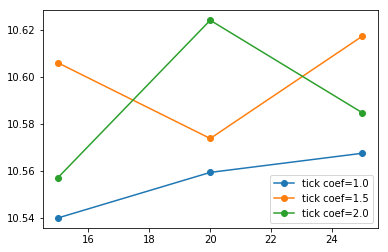

In [31]:
plt.plot(tick_window,grouped_slippage['slippage'].iloc[:,0],'o-',label='tick coef=1.0')
plt.plot(tick_window,grouped_slippage['slippage'].iloc[:,1],'o-',label='tick coef=1.5')
plt.plot(tick_window,grouped_slippage['slippage'].iloc[:,2],'o-',label='tick coef=2.0')
plt.legend()
plt.show()

b.sell side

In [26]:
# a list that stored all results in the schedule model
tick_sellside_result=[]
# set parameters for the schedule factor model
order_quantity = 300000
order_side = 's'
max_behind=2000
schedule_coef=1.5
tick_window=[15,20,25]
tick_coef=[1,1.5,2]

In [27]:
# test day 1
day=day1
for window in tick_window:
    for t_coef in tick_coef:
        results = vw2.algo_loop(day, order_side, order_quantity, vwap_coefs, max_behind, schedule_coef, window, t_coef)
        summary={'day':day.index[0].strftime("%Y-%m-%d"),
         'order_quantity':order_quantity, 
         'order_side':order_side,
         'parameters':{'tick_window':window, 'tick_coefficient':t_coef},
          'results': results}
        print(results['trades'].shares.sum())
        tick_sellside_result.append(summary)

2020-03-25 22:06:07:356784: Beginning VWAP run:s,300000 shares, max_behind:2000, schedule_coef: 1.5，tick_window:15,tick_coef:1
Average stock spread for sample: 0.0558
2020-03-25 22:06:07:558282: starting main loop
2020-03-25 22:09:39:109004: end simulation loop
2020-03-25 22:09:39:109191: order analytics
2020-03-25 22:09:39:220786: VWAP run complete.
300000.0
2020-03-25 22:09:39:324579: Beginning VWAP run:s,300000 shares, max_behind:2000, schedule_coef: 1.5，tick_window:15,tick_coef:1.5
Average stock spread for sample: 0.0558
2020-03-25 22:09:39:526286: starting main loop
2020-03-25 22:13:12:889053: end simulation loop
2020-03-25 22:13:12:889213: order analytics
2020-03-25 22:13:12:996764: VWAP run complete.
300000.0
2020-03-25 22:13:13:110333: Beginning VWAP run:s,300000 shares, max_behind:2000, schedule_coef: 1.5，tick_window:15,tick_coef:2
Average stock spread for sample: 0.0558
2020-03-25 22:13:13:351295: starting main loop
2020-03-25 22:17:15:633068: end simulation loop
2020-03-25 2

In [29]:
# test day 2
day=day2
for window in tick_window:
    for t_coef in tick_coef:
        results = vw2.algo_loop(day, order_side, order_quantity, vwap_coefs, max_behind, schedule_coef, window, t_coef)
        summary={'day':day.index[0].strftime("%Y-%m-%d"),
         'order_quantity':order_quantity, 
         'order_side':order_side,
         'parameters':{'tick_window':window, 'tick_coefficient':t_coef},
          'results': results}
        print(results['trades'].shares.sum())
        tick_sellside_result.append(summary)

2020-03-25 22:44:02:137652: Beginning VWAP run:s,300000 shares, max_behind:2000, schedule_coef: 1.5，tick_window:15,tick_coef:1
Average stock spread for sample: 0.0768
2020-03-25 22:44:02:469908: starting main loop
2020-03-25 22:49:56:731483: end simulation loop
2020-03-25 22:49:56:731616: order analytics
2020-03-25 22:49:56:905915: VWAP run complete.
300000.0
2020-03-25 22:49:57:057048: Beginning VWAP run:s,300000 shares, max_behind:2000, schedule_coef: 1.5，tick_window:15,tick_coef:1.5
Average stock spread for sample: 0.0768
2020-03-25 22:49:57:383281: starting main loop
2020-03-25 22:58:38:261618: end simulation loop
2020-03-25 22:58:38:261790: order analytics
2020-03-25 22:58:38:437518: VWAP run complete.
300000.0
2020-03-25 22:58:38:598561: Beginning VWAP run:s,300000 shares, max_behind:2000, schedule_coef: 1.5，tick_window:15,tick_coef:2
Average stock spread for sample: 0.0768
2020-03-25 22:58:38:918050: starting main loop
2020-03-25 23:04:26:696132: end simulation loop
2020-03-25 2

In [32]:
# test day 3
day=day3
for window in tick_window:
    for t_coef in tick_coef:
        results = vw2.algo_loop(day, order_side, order_quantity, vwap_coefs, max_behind, schedule_coef, window, t_coef)
        summary={'day':day.index[0].strftime("%Y-%m-%d"),
         'order_quantity':order_quantity, 
         'order_side':order_side,
         'parameters':{'tick_window':window, 'tick_coefficient':t_coef},
          'results': results}
        print(results['trades'].shares.sum())
        tick_sellside_result.append(summary)

2020-03-25 23:57:37:247204: Beginning VWAP run:s,300000 shares, max_behind:2000, schedule_coef: 1.5，tick_window:15,tick_coef:1
Average stock spread for sample: 0.0692
2020-03-25 23:57:37:561548: starting main loop
2020-03-26 00:02:46:249135: end simulation loop
2020-03-26 00:02:46:249319: order analytics
2020-03-26 00:02:46:385971: VWAP run complete.
300000.0
2020-03-26 00:02:46:526539: Beginning VWAP run:s,300000 shares, max_behind:2000, schedule_coef: 1.5，tick_window:15,tick_coef:1.5
Average stock spread for sample: 0.0692
2020-03-26 00:02:46:808537: starting main loop
2020-03-26 00:07:47:268180: end simulation loop
2020-03-26 00:07:47:268345: order analytics
2020-03-26 00:07:47:412052: VWAP run complete.
300000.0
2020-03-26 00:07:47:514485: Beginning VWAP run:s,300000 shares, max_behind:2000, schedule_coef: 1.5，tick_window:15,tick_coef:2
Average stock spread for sample: 0.0692
2020-03-26 00:07:47:769108: starting main loop
2020-03-26 00:16:02:603870: end simulation loop
2020-03-26 0

In [33]:
with open('tick_sellside_result.pkl', "wb") as f:
    pickle.dump(tick_sellside_result, f)

In [34]:
with open('tick_sellside_result.pkl', "rb") as f:
    tick_sellside_result=pickle.load(f)

In [35]:
## CALCULATE AVERAGE SLIPPAGE
#extract elements from result summary
slippage=map(lambda x: (x['day'],
                        x['parameters'],
                        x['results']['day_vwap'],
                        x['results']['avg_price']),
             tick_sellside_result)
# calculate day slippage
slippage=map(lambda x: [x[0],
                        x[1]['tick_window'],
                        x[1]['tick_coefficient'],
                        (x[2]-x[3])/x[2]*10000],
             slippage)
# calculate average slippage over three testing days
slippage=pd.DataFrame(slippage, columns =['date', 'tick_window', 'tick_coef', 'slippage']) 
grouped_slippage=slippage.groupby(['tick_window','tick_coef']).mean().unstack()

In [36]:
grouped_slippage

slippage                      
tick_coef          1.0        1.5        2.0
tick_window                                 
15           12.050607  12.559373  12.631577
20           12.024125  12.605964  12.597415
25           12.029545  12.010353  12.566619

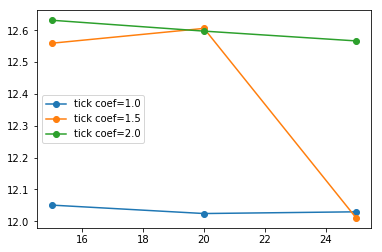

In [37]:
plt.plot(tick_window,grouped_slippage['slippage'].iloc[:,0],'o-',label='tick coef=1.0')
plt.plot(tick_window,grouped_slippage['slippage'].iloc[:,1],'o-',label='tick coef=1.5')
plt.plot(tick_window,grouped_slippage['slippage'].iloc[:,2],'o-',label='tick coef=2.0')
plt.legend()
plt.show()

### Limit Order

In [130]:
# set parameters for the schedule factor model
order_quantity = 300000
order_side = 'b'
max_behind=500
schedule_coef=1.5
tick_window=20
tick_coef=1
limit=250

day=day1
# without limit order
result5=vw3.algo_loop(day, order_side, order_quantity, vwap_coefs, 
                      max_behind, schedule_coef, tick_window, tick_coef)

2020-03-24 23:07:32:645620: Beginning VWAP run: b 300000 shares
Average stock spread for sample: 0.0558
2020-03-24 23:07:32:952282: starting main loop
2020-03-24 23:10:58:325905: end simulation loop
2020-03-24 23:10:58:326056: order analytics
2020-03-24 23:10:58:436388: VWAP run complete.


In [133]:
print(result5['trades'].shares.sum())
print(result5['day_vwap'])
print(result5['avg_price'])

300000.0
276.50274266679406
276.6577517


In [164]:
# with limit order and limit quantity per trade as keyword argument
# we add the limit quantity parameter to avoid market turbulence by dumping large quantity
limit_price=275
limit_quantity=10000
result6=vw3.algo_loop(day, order_side, order_quantity, vwap_coefs, 
                      max_behind, schedule_coef, tick_window, tick_coef, 
                      limit_price = limit, limit_quantity = limit_quantity)

2020-03-24 23:52:36:520542: Beginning VWAP run: b 300000 shares
Average stock spread for sample: 0.0558
2020-03-24 23:52:36:807717: starting main loop
2020-03-24 23:57:21:751158: end simulation loop
2020-03-24 23:57:21:751270: order analytics
2020-03-24 23:57:21:848638: VWAP run complete.


In [165]:
result6['trades']

,price,shares,bar,trade_type
2020-03-11 15:13:33.940418514,273,10000,343,a
2020-03-11 15:13:33.940434318,273,10000,343,a
2020-03-11 15:13:33.940438112,273,10000,343,a
2020-03-11 15:13:33.940438738,273,10000,343,a
2020-03-11 15:13:33.940448196,273,10000,343,a
2020-03-11 15:13:33.940497136,273,10000,343,a
2020-03-11 15:13:33.940520755,273,10000,343,a
2020-03-11 15:13:33.940520921,273,10000,343,a
2020-03-11 15:13:33.940544771,272.99,10000,343,a
2020-03-11 15:13:33.940749360,272.99,10000,343,a


In [166]:
result6['trades'].shares.sum()
# for limit orders, we do not guarantee that all order quantity be filled

258420.0

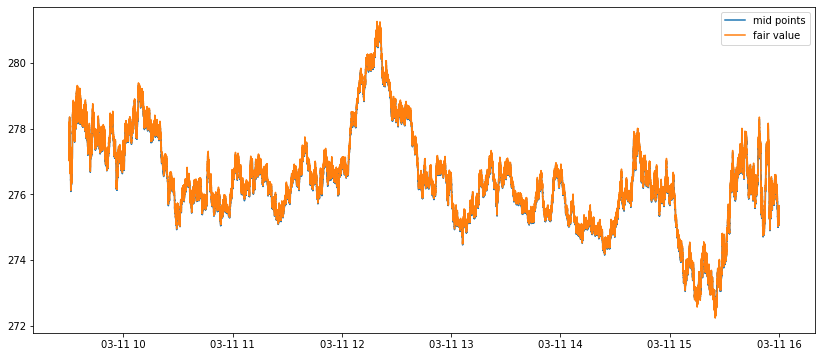

In [167]:
time=day.index.values
mid=result6['midpoints']
fv=result6['fair_values']
plt.plot(time,mid,label='mid points')
plt.plot(time,fv_limit,label='fair value')
plt.legend()
plt.show()